
# Оглавление

— [Подготовка](#Подготовка)

— [Анализ](#Анализ)

— [Обучение](#Обучение)

— [Тестирование](#Тестирование)

— [Общий-вывод](#Общий-вывод)

— [Чек-лист-проверки](#Чек-лист-проверки)


#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.sort_index(inplace=True)

In [5]:
data = data.resample('1H').sum()

In [6]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Данные без пропусков и выбросов

In [9]:
# Визуализируем исходные данные (с ресемплированием за день) и проверим на стационарность

data_by_day = data.resample('1D').sum()

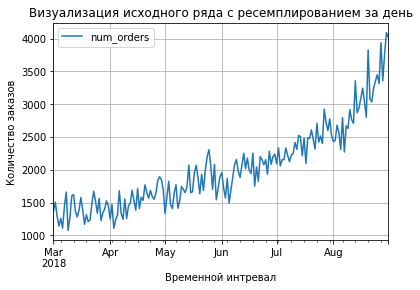

In [10]:
data_by_day.plot(grid=True, legend=True)
plt.title('Визуализация исходного ряда с ресемплированием за день')
plt.xlabel('Временной интревал')
plt.ylabel('Количество заказов')
plt.show()

График не стационарный, так как его значение среднего все время растет

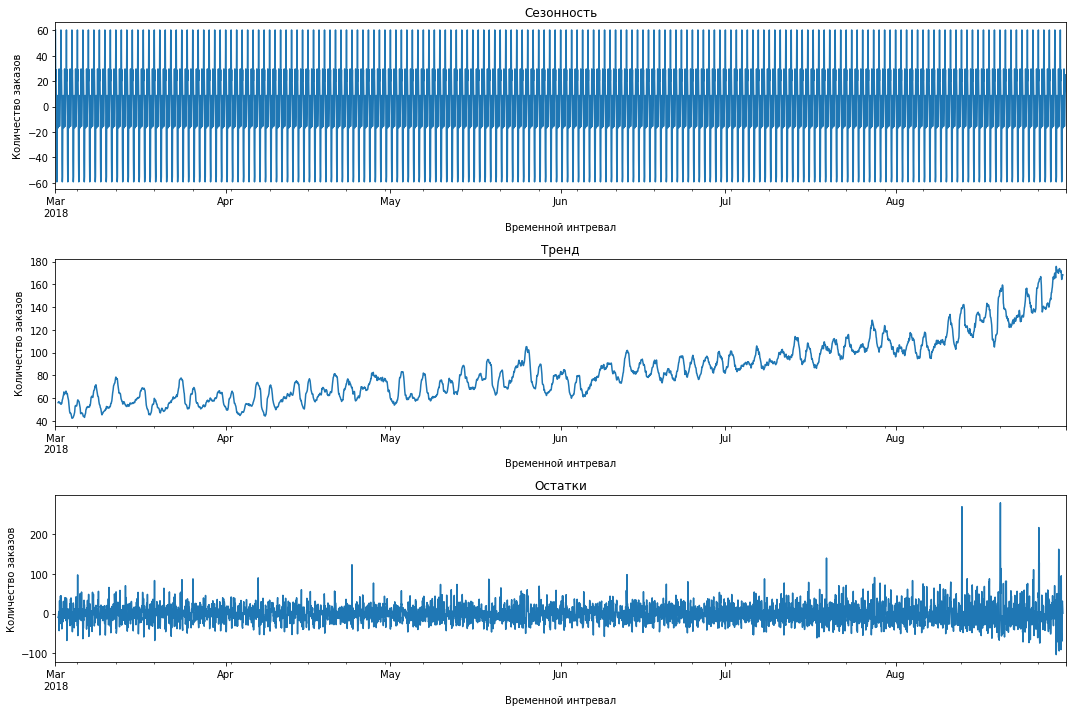

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 10));
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.xlabel('Временной интревал')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Временной интревал')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.xlabel('Временной интревал')
plt.ylabel('Количество заказов')
plt.tight_layout()

Тренд растет с каждым месяцем

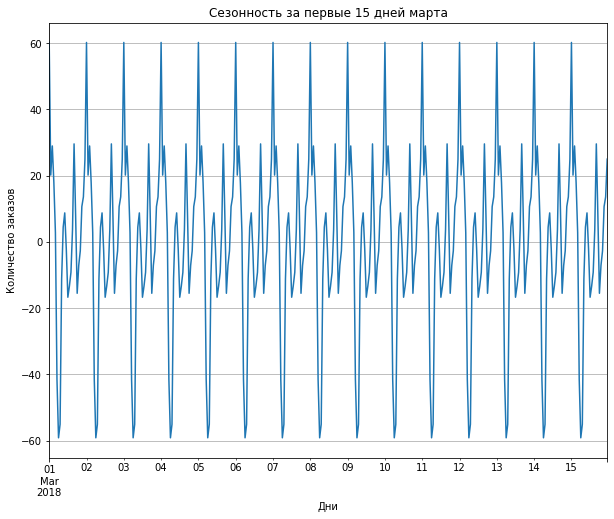

In [12]:
# посмотрим график сезонной составляющей за первые 15 дней марта

plt.figure(figsize=(10, 8))
decomposed.seasonal['2018-03-01' : '2018-03-15'].plot(ax=plt.gca())
plt.title('Сезонность за первые 15 дней марта')
plt.xlabel("Дни")
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

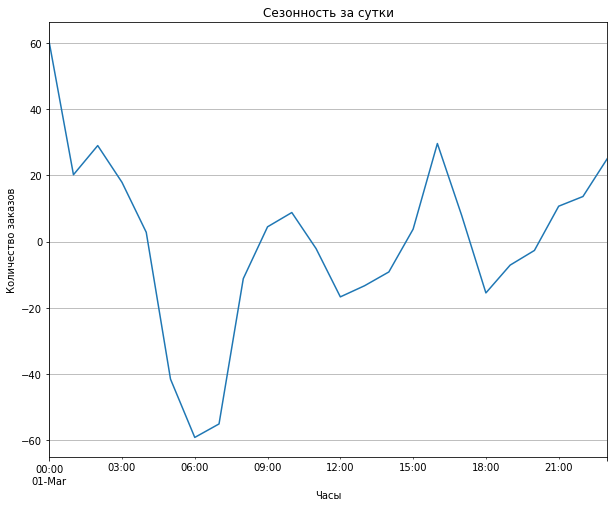

In [13]:
# график сезонной составляющей за сутки

plt.figure(figsize=(10, 8))

decomposed.seasonal['2018-03-01' : '2018-03-01'].plot(ax=plt.gca())

plt.title('Сезонность за сутки')
plt.xlabel("Часы")
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

Пики активности: 00.00, 2.00, 10.00, 16.00

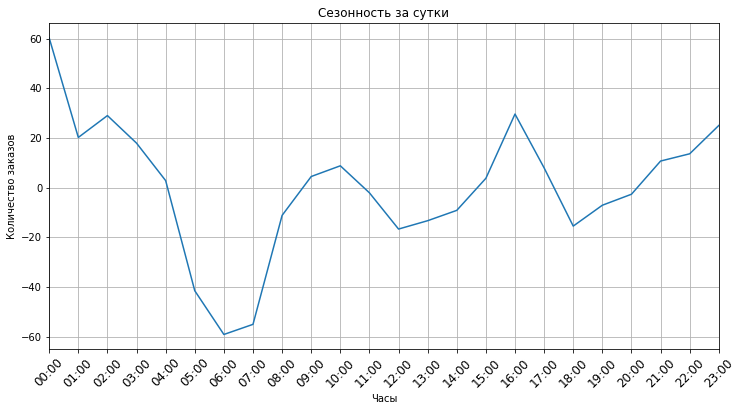

In [38]:
#code review
plt.figure(figsize=(12, 6))

s = decomposed.seasonal['2018-03-01' : '2018-03-01']
s.plot(ax=plt.gca())

plt.title('Сезонность за сутки')
plt.xlabel("Часы")
plt.ylabel('Количество заказов')

# Получаем текущие отметки и подписи по оси Х
locs, labels = plt.xticks()

# формируем новые подписи
plt.xticks(np.linspace(locs[0], locs[1], len(s)), [d.strftime('%H:00') for d in s.index], rotation=45, fontsize=12)

plt.grid(True)
plt.show()

### Вывод

- Данные без пропусков и аномалий
- Исходные данные визуализированы. График стремится вверх, делаю вывод, что он не стационарный, так как его среднее значение все время растет.
- Реализована сезонная декомпозиция: Тренд у нас связан с каждым месяцем, сезонность сложно оценить, так как рост спроса на такси только растет и данных слишком мало. Спрос растет по вторникам и пятницам.
- Визуализирована декомпозиция за сутки. Пики активности: 00.00, 2.00, 10.00, 16.00

## Обучение

In [21]:
# Создадим признаки для горизонта прогнозирования

def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

In [22]:
make_features(data, 20, 20)

In [23]:
data.head(10)

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,1,3,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,1,3,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,7,1,3,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,8,1,3,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Делим на выборки


In [24]:
train, test = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)
train = train.dropna()

features_train = train.drop(['num_orders'] , axis=1)
features_valid = valid.drop(['num_orders'] , axis=1)
features_test = test.drop(['num_orders'] , axis=1)

target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

In [25]:
train.shape

(3512, 25)

In [26]:
valid.shape

(442, 25)

In [27]:
test.shape

(442, 25)

In [28]:
# функция подбора гиперпараметров моделей

def select_best_params_for_models(model_container, features_train, target_train, features_valid, target_valid, **kwargs):
    rmse, max_num  = [], []

    for num in range(10, 201, 10):
        model = model_container(num)
        model.fit(features_train, target_train, **kwargs)
        target_predict = model.predict(features_valid)

        max_num.append(num)
        rmse.append(mean_squared_error(target_valid, target_predict)**0.5)

        print("max_quantity =", num, ": ", rmse[-1])
    return rmse, max_num

###  ElasticNet 

In [29]:
elastic_model = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],cv=5, max_iter=100000)

In [30]:
elastic_model.fit(features_train, target_train)

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             max_iter=100000)

In [31]:
y_pred_elastic = elastic_model.predict(features_valid)

In [32]:
rmse_elastic = mean_squared_error(target_valid, y_pred_elastic)**0.5

In [33]:
rmse_elastic

40.52214346426268

###  Случайный лес

In [34]:
select_best_params_for_models(
    lambda num: RandomForestRegressor(
        n_estimators=num,
        max_depth=None, 
        random_state=12345
    ),
    features_train, 
    target_train, 
    features_valid, 
    target_valid
);

max_quantity = 10 :  33.183999238034346
max_quantity = 20 :  32.67020571757942
max_quantity = 30 :  32.194900784142106
max_quantity = 40 :  31.847186805265896
max_quantity = 50 :  31.656652135600016
max_quantity = 60 :  31.698030114222743
max_quantity = 70 :  31.60707239811151
max_quantity = 80 :  31.54971684035291
max_quantity = 90 :  31.61678532777928
max_quantity = 100 :  31.61067844661363
max_quantity = 110 :  31.654698589379873
max_quantity = 120 :  31.58479184689706
max_quantity = 130 :  31.541179437277222
max_quantity = 140 :  31.57893037659445
max_quantity = 150 :  31.527710599503628
max_quantity = 160 :  31.580632835342048
max_quantity = 170 :  31.550408806969422
max_quantity = 180 :  31.52372985488907
max_quantity = 190 :  31.57312657217722
max_quantity = 200 :  31.564820696458064


In [35]:
random_forest = RandomForestRegressor(
        n_estimators=150,
        max_depth=None, 
        random_state=12345
    )
random_forest.fit(features_train, target_train)

RandomForestRegressor(n_estimators=150, random_state=12345)

In [36]:
target_predict = random_forest.predict(features_valid)

In [37]:
rmse_random_forest = mean_squared_error(target_valid, target_predict)**0.5

In [38]:
rmse_random_forest

31.527710599503628

###  Cat Boost

In [39]:
select_best_params_for_models(
    lambda num: CatBoostRegressor(loss_function="RMSE", iterations=num),
    features_train, 
    target_train, 
    features_valid, 
    target_valid,
    verbose=False
);

max_quantity = 10 :  34.21450646689077
max_quantity = 20 :  32.868799540318825
max_quantity = 30 :  32.672682345304324
max_quantity = 40 :  32.19292714656223
max_quantity = 50 :  32.768510874109715
max_quantity = 60 :  32.408446334372265
max_quantity = 70 :  31.97806232071821
max_quantity = 80 :  32.561048962161095
max_quantity = 90 :  32.61772372847971
max_quantity = 100 :  32.12963051780795
max_quantity = 110 :  32.97317550076661
max_quantity = 120 :  31.50820074213783
max_quantity = 130 :  31.50471193244499
max_quantity = 140 :  31.966993338690582
max_quantity = 150 :  31.334054443302264
max_quantity = 160 :  30.40593161992231
max_quantity = 170 :  30.936610500647127
max_quantity = 180 :  31.42958313169012
max_quantity = 190 :  31.577211706928857
max_quantity = 200 :  31.32493545562685


In [40]:
cat = CatBoostRegressor(loss_function="RMSE", iterations=160, verbose=0)
cat.fit(features_train, target_train)

In [41]:
target_predict = cat.predict(features_valid)

In [42]:
rmse_cat = mean_squared_error(target_valid, target_predict)**0.5

In [43]:
rmse_cat

30.40593161992231

### Вывод

Все модели получили значение rmse меньше 48

## Тестирование

###  Cat Boost

In [44]:
features_trainvalid = pd.concat([features_train, features_valid])
target_trainvalid = pd.concat([target_train, target_valid])

In [45]:
cat = CatBoostRegressor(loss_function="RMSE", iterations=160, verbose=0)
cat.fit(features_trainvalid, target_trainvalid)

In [46]:
target_predict = cat.predict(features_test)

In [47]:
rmse_cat = mean_squared_error(target_test, target_predict)**0.5

In [48]:
rmse_cat

45.29891024048083

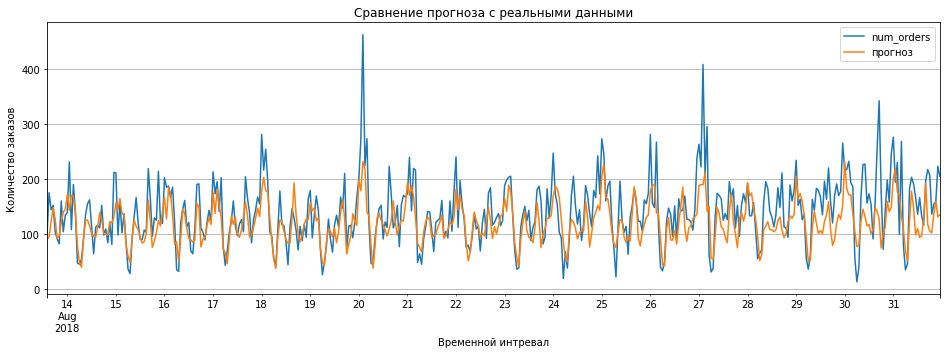

In [49]:
# визуализируем прогноз лучшей модели на тестовой выборке - график прогноз-факт

predictions_plot = pd.Series(data = target_predict, name = 'прогноз', index = features_test.index)

target_test.plot(figsize=(16,5), grid=True, legend=True)
predictions_plot.plot(grid=True, legend=True)
plt.title('Сравнение прогноза с реальными данными')
plt.xlabel('Временной интревал')
plt.ylabel('Количество заказов')
plt.show()

### Вывод

- Cat Boost показала результат - 45.2.
- Прогноз не особо отстает от реальных данных

## Общий вывод

- Данные подготовлены и проанализиованы. Пропусков и выбросов не оказалось.

- Выбраны и обучены 3 модели: ElasticNet, Случайный лес и Cat Boost. На валидационной выборке все модели показали результат в пределах 48. Cat Boost показала лучший резульат.

- Протестирована лучшая модель Cat Boost. Результат на тесте 45.2

- Построен график прогноз-факт, где прогноз не особо отстает от реальных данных

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48